# Modelling coupled degradation mechanisms in PyBaMM

This notebook shows how to set up a PyBaMM model in which many degradation mechanisms run at the same time and interact with one another.

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


O'Kane et al. [10] modelled four coupled degradation mechanisms: SEI growth, lithium plating, particle cracking and stress-driven loss of active material. The "SEI on cracks" option couples SEI growth and particle cracking by allowing SEI to grow on the cracks. The "partially reversible" option for lithium plating allows the SEI to influence the irreversible component of plating using a function in the OKane2022 parameter file. Particle cracking and stress-driven loss of active material are coupled by default because the stress-strain relations inside the particles are an input for both.

In [2]:
model = pybamm.lithium_ion.DFN(
    {
        #"particle phases": ("2", "1"),
        #"open-circuit potential": (("single", "current sigmoid"), "single"),
        
        "SEI": "solvent-diffusion limited",
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "SEI on cracks": "true",
        "loss of active material": "stress-driven",
        "calculate discharge energy": "true",  # for compatibility with older PyBaMM versions

        #"thermal": "lumped", 
    }
)

Depending on the parameter set being used, the particle cracking model can require a large number of mesh points inside the particles to be numerically stable.

In [2]:
param = pybamm.ParameterValues("OKane2022_posmolar_0703")
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator
    "x_p": 5,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 30,  # positive particle
}

In [3]:
param["Positive electrode partial molar volume [m3.mol-1]"]

3.1e-06

In [5]:
# Convert KeysView object to a list and print the list
parameter_set_keys = list(pybamm.parameter_sets.keys())
print(parameter_set_keys)


['Ai2020', 'Chen2020', 'Chen2020_composite', 'ECM_Example', 'Ecker2015', 'Ecker2015_graphite_halfcell', 'MSMR_Example', 'Marquis2019', 'Mohtat2020', 'NCA_Kim2011', 'OKane2022', 'OKane2022_graphite_SiOx_halfcell', 'OKane2022_posmolar_0703', 'ORegan2022', 'Prada2013', 'Ramadass2004', 'Sulzer2019', 'Xu2019']


Define a cycling protocol and solve. The protocol from O'Kane et al. [10] is used here, except with 10 ageing cycles instead of 1000.

In [7]:
cycle_number = 3
exp = pybamm.Experiment(
    # [
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    #     "Rest for 4 hours (5 minute period)",
    #     "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
    #     "Charge at 1C until 4.2 V (5 minute period)",
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    # ]
    # + 
    [
        (
            "Discharge at 1C until 2.5 V",  # ageing cycles
            "Charge at 1C until 4.2 V (5 minute period)",
            "Hold at 4.2 V until C/100 (5 minute period)",
        )
    ]
    * cycle_number
    + ["Discharge at 0.1C until 2.5 V (5 minute period)"],  # final capacity check
)
sim = pybamm.Simulation(model, parameter_values=param, experiment=exp, var_pts=var_pts)
sol = sim.solve()

At t = 472.482 and h = 1.2272e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 232.482 and h = 1.246e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 360.369 and h = 2.60363e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 123.328 and h = 2.13777e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 430.68 and h = 7.80337e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 190.68 and h = 1.03059e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Three of the degradation mechanisms - SEI, lithium plating and SEI on cracks - cause loss of lithium inventory (LLI). Plotting the different contributions to LLI against throughput capacity as opposed to cycle number allows them to be considered as continuous variables as opposed to discrete ones.

In [ ]:
model.variables

{'Time [s]': Time(-0x707a53495b64665e, time, children=[], domains={}),
 'Time [min]': Multiplication(-0x262861fe466dad80, *, children=['0.016666666666666666', 'time'], domains={}),
 'Time [h]': Multiplication(-0x6d7e6d3fc81788b0, *, children=['0.0002777777777777778', 'time'], domains={}),
 'x [m]': SpatialVariable(-0x39abc2f2d3ffb0cd, x, children=[], domains={'primary': ['negative electrode', 'separator', 'positive electrode'], 'secondary': ['current collector']}),
 'x_n [m]': SpatialVariable(-0x1ffe5e3917b58208, x_n, children=[], domains={'primary': ['negative electrode'], 'secondary': ['current collector']}),
 'x_s [m]': SpatialVariable(-0x4eb7dfc71757c426, x_s, children=[], domains={'primary': ['separator'], 'secondary': ['current collector']}),
 'x_p [m]': SpatialVariable(0x6e7d26c95f981af9, x_p, children=[], domains={'primary': ['positive electrode'], 'secondary': ['current collector']}),
 'r_n [m]': SpatialVariable(-0x10f9f8a98a21087a, r_n, children=[], domains={'primary': ['nega

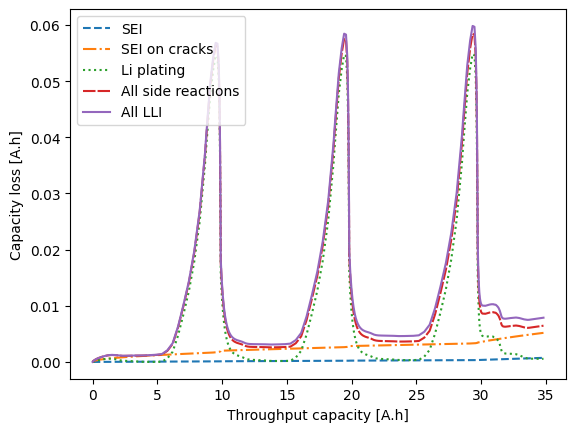

In [9]:
Qt = sol["Throughput capacity [A.h]"].entries
Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
Q_SEI_cr = sol["Loss of capacity to negative SEI on cracks [A.h]"].entries
Q_plating = sol["Loss of capacity to negative lithium plating [A.h]"].entries
Q_side = sol["Total capacity lost to side reactions [A.h]"].entries
Q_LLI = (
    sol["Total lithium lost [mol]"].entries * 96485.3 / 3600
)  # convert from mol to A.h
plt.figure()
plt.plot(Qt, Q_SEI, label="SEI", linestyle="dashed")
plt.plot(Qt, Q_SEI_cr, label="SEI on cracks", linestyle="dashdot")
plt.plot(Qt, Q_plating, label="Li plating", linestyle="dotted")
plt.plot(Qt, Q_side, label="All side reactions", linestyle=(0, (6, 1)))
plt.plot(Qt, Q_LLI, label="All LLI")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Capacity loss [A.h]")
plt.legend()
plt.show()

In [10]:
Thickness = sol["Cell thickness change [m]"].entries
Thickness_neg = sol["Negative electrode thickness change [m]"].entries
Thickness_pos = sol["Positive electrode thickness change [m]"].entries
Voltage = sol["Voltage [V]"].entries

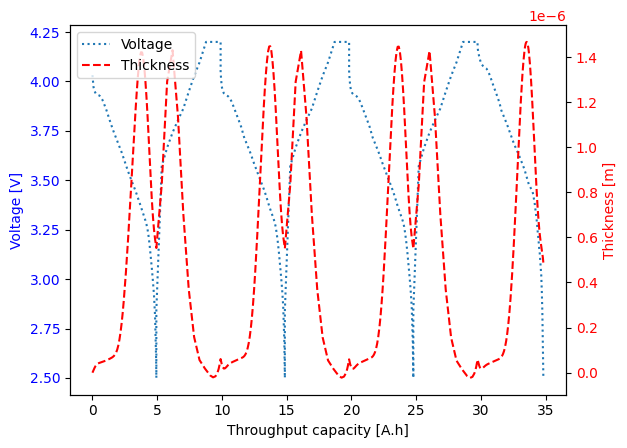

In [11]:
import matplotlib.pyplot as plt

# 假设 Qt, Voltage 和 Thickness 是已经定义的数据
# 例如：
# Qt = [1, 2, 3, 4, 5]
# Voltage = [2.1, 2.3, 2.2, 2.5, 2.7]
# Thickness = [0.1, 0.15, 0.13, 0.18, 0.2]

# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(Qt, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Throughput capacity [A.h]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(Qt, Thickness, label="Thickness", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.set_ylabel("Thickness [m]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()


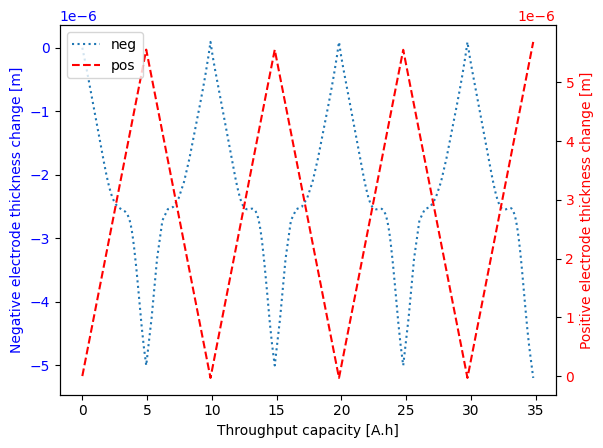

In [12]:



# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(Qt, Thickness_neg, label="neg", linestyle="dotted")
ax1.set_xlabel("Throughput capacity [A.h]")
ax1.set_ylabel("Negative electrode thickness change [m]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(Qt, Thickness_pos, label="pos", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.set_ylabel("Positive electrode thickness change [m]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

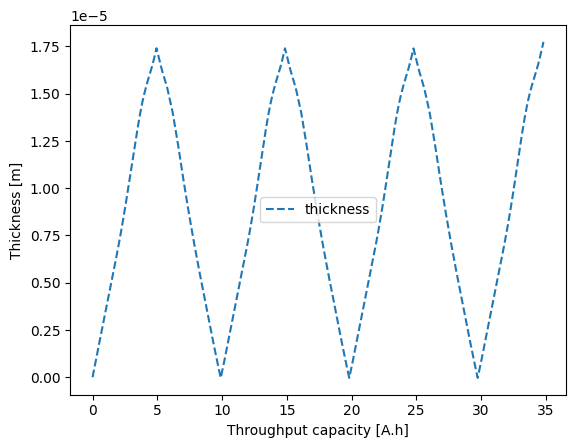

In [ ]:
plt.figure()
plt.plot(Qt, Thickness, label="thickness", linestyle="dashed")

plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Thickness [m]")
plt.legend()
plt.show()

In [ ]:
Thickness

array([ 7.37850400e-18,  2.95945829e-07,  5.91231027e-07,  8.84301206e-07,
        1.17486191e-06,  1.46330342e-06,  1.75029241e-06,  2.03650854e-06,
        2.32248074e-06,  2.60854302e-06,  2.89483127e-06,  3.18134530e-06,
        3.46800141e-06,  3.75471965e-06,  4.04146068e-06,  4.32826970e-06,
        4.61518549e-06,  4.90225119e-06,  5.18964076e-06,  5.47763586e-06,
        5.76667348e-06,  6.05745710e-06,  6.35099777e-06,  6.64863634e-06,
        6.95174431e-06,  7.26117834e-06,  7.57753897e-06,  7.90132028e-06,
        8.23250894e-06,  8.57104508e-06,  8.91590231e-06,  9.26682574e-06,
        9.62270666e-06,  9.98295712e-06,  1.03467371e-05,  1.07132591e-05,
        1.10815545e-05,  1.14506181e-05,  1.18196691e-05,  1.21870955e-05,
        1.25511892e-05,  1.29099322e-05,  1.32604338e-05,  1.35992652e-05,
        1.39226335e-05,  1.42276305e-05,  1.45110154e-05,  1.47729361e-05,
        1.50159206e-05,  1.52427734e-05,  1.54564349e-05,  1.56582764e-05,
        1.58499512e-05,  

The capacity loss over 10 cycles is so small that the reversible component of the lithium plating is has a larger effect than all the irreversible mechanisms combined. Most of the irreversible capacity fade that does occur is caused by SEI on cracks.

The stress-driven loss of active material (LAM) mechanism [10,11] is also included, so the three main degradation modes - LLI and LAM in each electrode - can be plotted and compared.

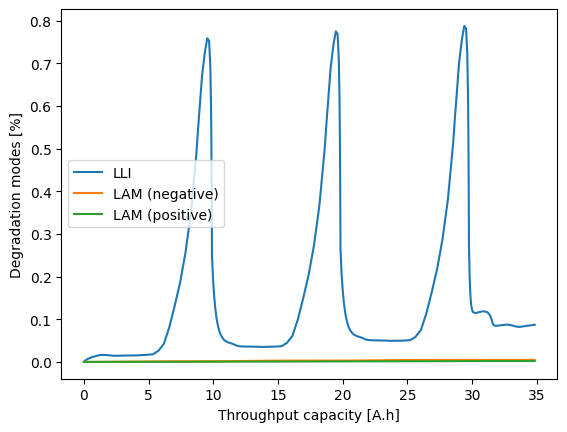

In [ ]:
Qt = sol["Throughput capacity [A.h]"].entries
LLI = sol["Loss of lithium inventory [%]"].entries
LAM_neg = sol["Loss of active material in negative electrode [%]"].entries
LAM_pos = sol["Loss of active material in positive electrode [%]"].entries
plt.figure()
plt.plot(Qt, LLI, label="LLI")
plt.plot(Qt, LAM_neg, label="LAM (negative)")
plt.plot(Qt, LAM_pos, label="LAM (positive)")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Degradation modes [%]")
plt.legend()
plt.show()

Both the reversible and irreversible components of LLI are far greater than LAM for this parameter set.

A key internal variable is the porosity. Pore clogging by SEI, lithium plating and other means can trigger other degradation mechanisms and reduce the rate capability of the cell. If the porosity reaches zero, the cell becomes completely unusable and PyBaMM will terminate the simulation.

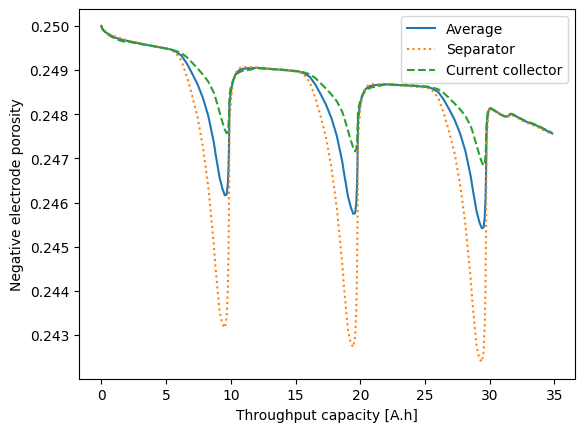

In [ ]:
eps_neg_avg = sol["X-averaged negative electrode porosity"].entries
eps_neg_sep = sol["Negative electrode porosity"].entries[-1, :]
eps_neg_CC = sol["Negative electrode porosity"].entries[0, :]
plt.figure()
plt.plot(Qt, eps_neg_avg, label="Average")
plt.plot(Qt, eps_neg_sep, label="Separator", linestyle="dotted")
plt.plot(Qt, eps_neg_CC, label="Current collector", linestyle="dashed")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Negative electrode porosity")
plt.legend()
plt.show()

If you want to see some serious degradation, try re-running the simulation with more ageing cycles, or using param.update({}) to increase the degradation parameters beyond the ranges considered by O'Kane et al. [10]

In [ ]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[4] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical S